# COVID Data Preparation

In diesem Notebook werden die einzelnen Rohdaten aus verschiedenen Quellen zusammengeführt und in einer CSV-Datei gespeichert.
Die Datenaufbereitung und -selektion findet in einem weiteren Notebook statt.

## Imports and File Paths

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
FILE_PATH_OWID_COVID_CSV = "./raw/covid-19-data/public/data/owid-covid-data.csv"
FILE_PATH_WHO_DOCTORS = "./raw/who-datasets/Medical doctors (per 10,000).csv"
FILE_PATH_GHS_INDEX = "./raw/ghs-index/Global Health Security Index (Overall Score).csv"
FILE_PATH_WORLDBANK_HEALTH_EXPENDITURE = "./raw/worldbank-datasets/Current health expenditure (% of GDP).csv"
FILE_PATH_WORLDBANK_GDP = "./raw/worldbank-datasets/GDP.csv"
FILE_PATH_WORLDBANK_DEVELOPMENT = "./raw/worldbank-datasets/Development.csv"
FILE_PATH_WORLDBANK_POVERTY = "./raw/worldbank-datasets/Poverty.csv"
FILE_PATH_WORLDBANK_POVERTY2 = "./raw/worldbank-datasets/Poverty2.csv"
FILE_PATH_KAGGLE_MALNUTRITION = "./raw/kaggle-datasets/malnutrition.csv"
FILE_PATH_KAGGLE_LOCKDOWN = "./raw/kaggle-datasets/countryLockdowndates.csv"
FILE_PATH_WORLDBANK_MORTALITY = "./raw/worldbank-datasets/Mortality.csv"
FILE_PATH_WORLDBANK_TRAVEL_TOURISM = "./raw/worldbank-datasets/TravelAndTourism.csv"
FILE_PATH_DEMOCRACY_INDEX = "./raw/democracy-index/Democracy Index (2019).csv"
FILE_PATH_UN_HOUSEHOLDS = "./raw/un/households.csv"

## COVID Numbers per Country

In [3]:
df = pd.read_csv(FILE_PATH_OWID_COVID_CSV)
df = df[(df.iso_code != 'OWID_WRL') & (df.total_cases.notnull())].sort_values(
                'date', ascending=False).groupby('iso_code').first().reset_index()
df = df.loc[:, ['iso_code','continent','location','date','total_cases','total_deaths',
                'total_cases_per_million','aged_70_older','gdp_per_capita','extreme_poverty',
                'cvd_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities']]

In [4]:
print(df.head())

  iso_code      continent     location        date  total_cases  total_deaths  \
0      ABW  North America        Aruba  2020-06-23        101.0           3.0   
1      AFG           Asia  Afghanistan  2020-06-23      29143.0         598.0   
2      AGO         Africa       Angola  2020-06-23        183.0           9.0   
3      AIA  North America     Anguilla  2020-06-23          3.0           0.0   
4      ALB         Europe      Albania  2020-06-23       1995.0          44.0   

   total_cases_per_million  aged_70_older  gdp_per_capita  extreme_poverty  \
0                  945.994          7.452       35973.781              NaN   
1                  748.632          1.337        1803.987              NaN   
2                    5.568          1.362        5819.495              NaN   
3                  199.973            NaN             NaN              NaN   
4                  693.238          8.643       11803.431              1.1   

   cvd_death_rate  diabetes_prevalence  fema

(209, 15)


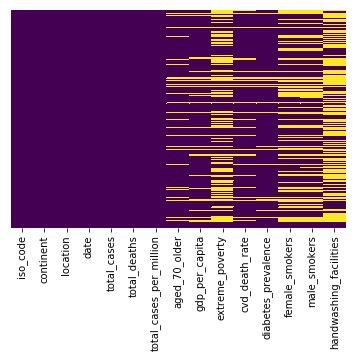

In [5]:
print(df.shape)
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## WHO Medical Doctors per Country

In [6]:
df_doctors = pd.read_csv(FILE_PATH_WHO_DOCTORS)
df_doctors.rename(columns={'Location':'location','Period':'year','First Tooltip':'medical_doctors'}, inplace=True)
df_doctors = df_doctors.loc[:, ['location','medical_doctors']]

def rename_countries_doctors(country):
    mapping = { 'Bolivia (Plurinational State of)':'Bolivia', 'Brunei Darussalam':'Brunei',
               'Cabo Verde':'Cape Verde', 'Eswatini':'Swaziland',
               'Côte d’Ivoire':'Cote d\'Ivoire', 'Czechia':'Czech Republic',
               'Democratic Republic of the Congo':'Democratic Republic of Congo',
               'Iran (Islamic Republic of)':'Iran',
               'Lao People\'s Democratic Republic':'Laos',
               'The former Yugoslav Republic of Macedonia':'Macedonia',
               'Republic of Moldova':'Moldova', 'Russian Federation':'Russia',
               'Republic of Korea':'South Korea', 'Syrian Arab Republic':'Syria',
               'United Kingdom of Great Britain and Northern Ireland':'United Kingdom',
               'United States of America':'United States',
               'United Republic of Tanzania':'Tanzania', 'Viet Nam':'Vietnam',
               'Venezuela (Bolivarian Republic of)':'Venezuela',
              }
    if (country in mapping):
        return mapping[country]
    return country

df_doctors['location'] = df_doctors['location'].apply(lambda x: rename_countries_doctors(x))

df = df.merge(df_doctors, how = 'left', on = ['location'])

## Global Health Security Index per Country

(209, 17)


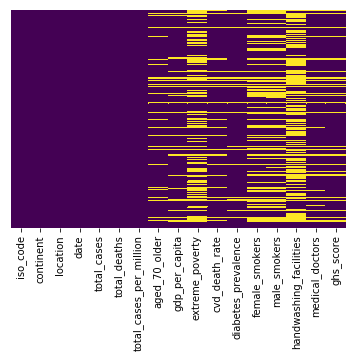

In [7]:
df_ghs = pd.read_csv(FILE_PATH_GHS_INDEX)

df_ghs.rename(columns={'country':'location', 'ghs_score':'ghs_score'}, inplace=True)
df_ghs = df_ghs.loc[:, ['location','ghs_score']]

df = df.merge(df_ghs, how = 'left', on = ['location'])

print(df.shape)
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## Current Health Expenditure per Country

(209, 18)


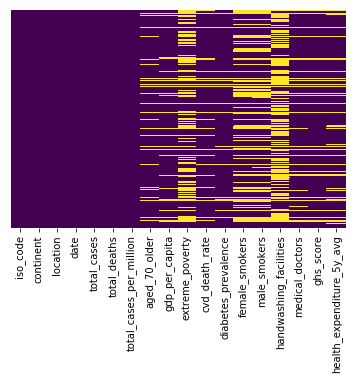

In [8]:
df_health_expenditure = pd.read_csv(FILE_PATH_WORLDBANK_HEALTH_EXPENDITURE)

years = [2017, 2016, 2015, 2014, 2013]

countries = []
health_expenditure_5y_avg = []
for index, row in df_health_expenditure.iterrows():
    values = []
    for year in years:
        value = row[str(year)]
        if (math.isnan(value)):
            break
        values.append(value)
    if (len(values) == len(years)):
        countries.append(row["Country Code"])
        health_expenditure_5y_avg.append(sum(values)/len(values))

df_health_exprenditure_5y_avg = pd.DataFrame({
    'iso_code': countries,
    'health_expenditure_5y_avg': health_expenditure_5y_avg,
})

df = df.merge(df_health_exprenditure_5y_avg, how = 'left', on = ['iso_code'])

print(df.shape)
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## World Bank - World Development Indicators

(209, 27)


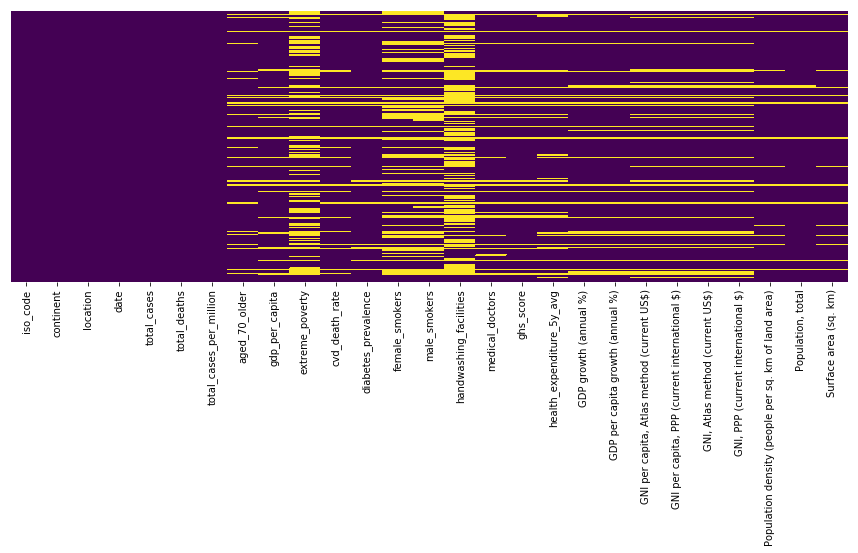

In [9]:
df_wb_gdp = pd.read_csv(FILE_PATH_WORLDBANK_GDP)

df_wb_gdp.rename(columns={'Country Name':'location', 'Country Code': 'iso_code'}, inplace=True)
df_wb_gdp = df_wb_gdp.pivot_table(index=['iso_code'], columns='Series Name', values='2018 [YR2018]').reset_index()

df = df.merge(df_wb_gdp, how = 'left', on = ['iso_code'])

print(df.shape)
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

## World Bank - Development

(209, 35)


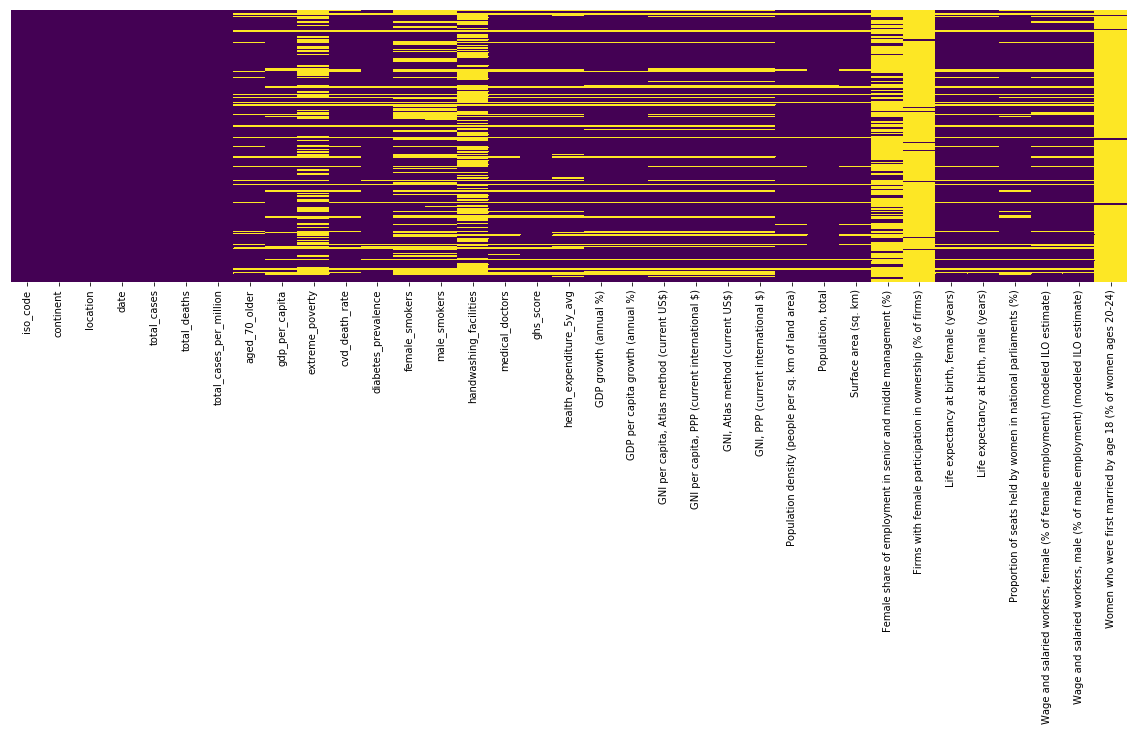

In [10]:
df_wb_dev = pd.read_csv(FILE_PATH_WORLDBANK_DEVELOPMENT)

df_wb_dev.rename(columns={'Country Name':'location', 'Country Code': 'iso_code'}, inplace=True)
df_wb_dev = df_wb_dev.pivot_table(index=['iso_code'], columns='Series Name', values='2018 [YR2018]').reset_index()

df = df.merge(df_wb_dev, how = 'left', on = ['iso_code'])

print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

## Malnutrition per Country

In [11]:
df_malnutrition_set = pd.read_csv(FILE_PATH_KAGGLE_MALNUTRITION)
df_malnutrition = df_malnutrition_set.loc[:, ['Country', 'Overweight', 'Stunting', 'Underweight']]
df_malnutrition['Country'] = df_malnutrition['Country'].apply(lambda x:x.title())
df_malnutrition.rename(columns={'Country':'location', 'Overweight':'overweight_in_percent', 'Stunting':'stunting_in_percent', 'Underweight':'underweight_in_percent'}, inplace=True)
print(df_malnutrition.shape)
df = df.merge(df_malnutrition, how = 'left', on = ['location'])

(152, 4)


(209, 38)


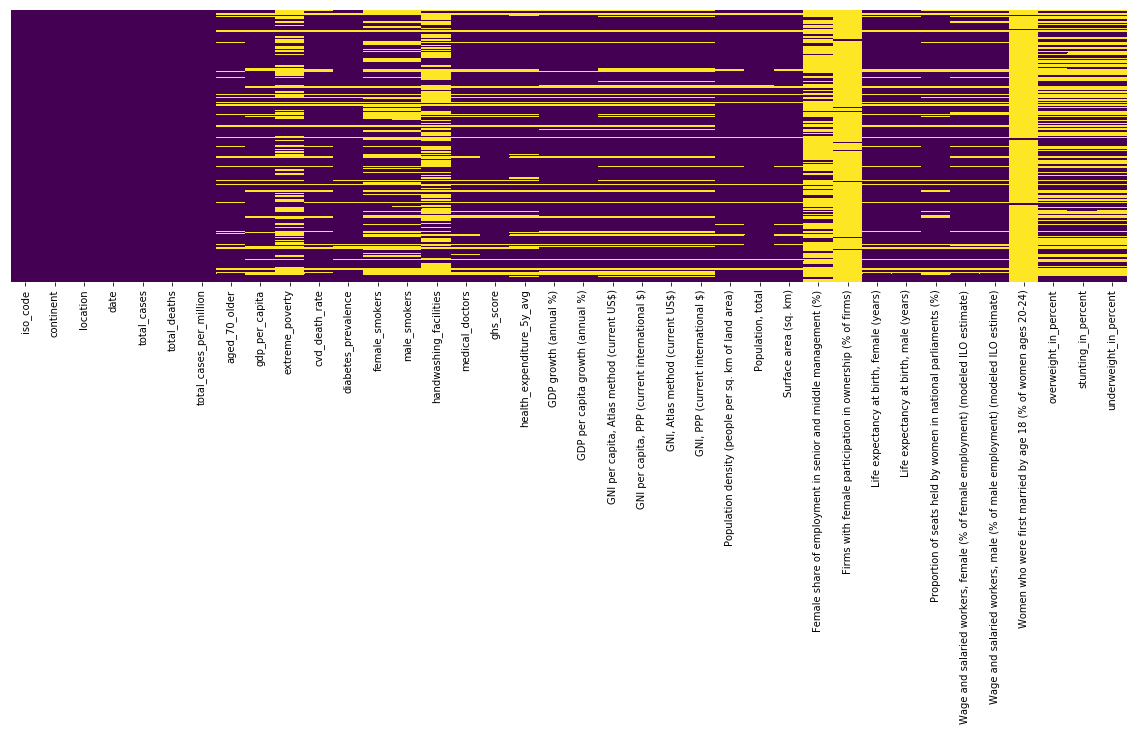

In [12]:
print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

# World Bank - Mortality

In [13]:
df_mortality_set = pd.read_csv(FILE_PATH_WORLDBANK_MORTALITY)
df_mortality_set.rename(columns={'Country Name':'location', 'Country Code': 'iso_code'}, inplace=True)
df_mortality = df_mortality_set.pivot_table(index=['iso_code'], columns='Series Name', values='2018 [YR2018]').reset_index()
df_mortality = df_mortality.loc[:, ['iso_code', 'Mortality rate, adult, female (per 1,000 female adults)', 'Mortality rate, adult, male (per 1,000 male adults)']]
print(df_mortality.shape)

(254, 3)


(209, 40)


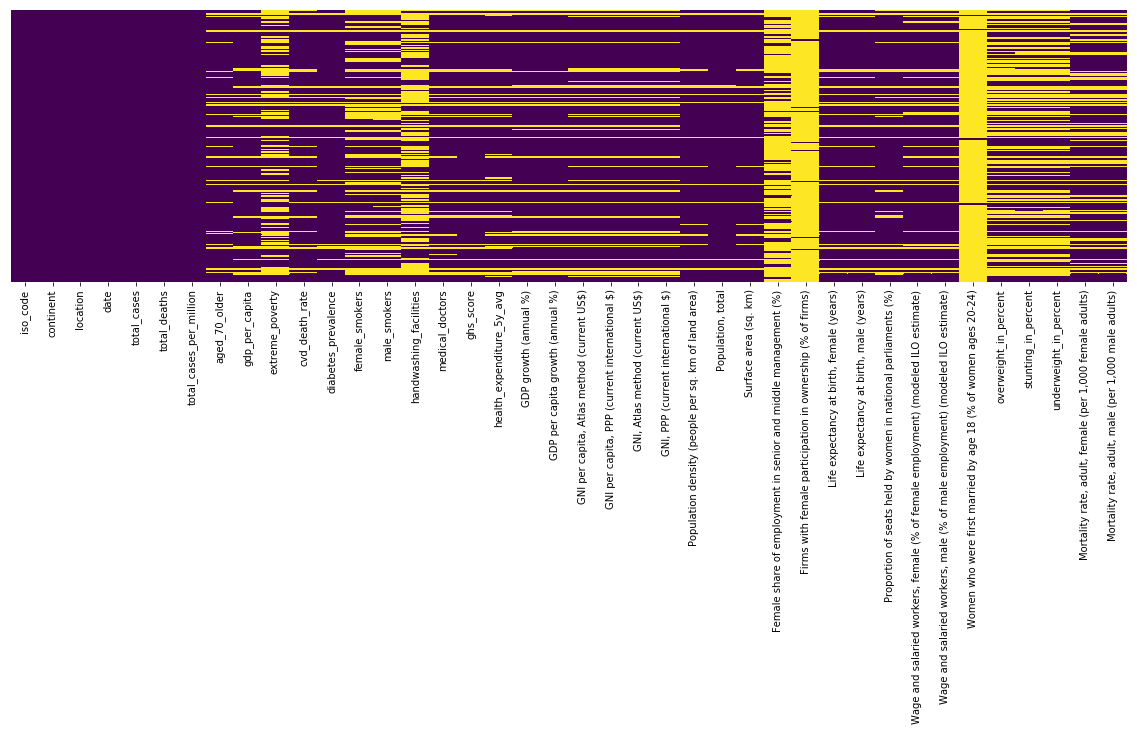

In [14]:
df = df.merge(df_mortality, how = 'left', on = ['iso_code'])
print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

# World Bank - Travel and Tourism

In [15]:
df_travel_tourism_set = pd.read_csv(FILE_PATH_WORLDBANK_TRAVEL_TOURISM)
df_travel_tourism_set.rename(columns={'Country Name':'location', 'Country Code': 'iso_code'}, inplace=True)
df_travel_tourism = df_travel_tourism_set.pivot_table(index=['iso_code'], columns='Series Name', values='2018 [YR2018]').reset_index()
print(df_travel_tourism.shape)

(242, 7)


(209, 46)


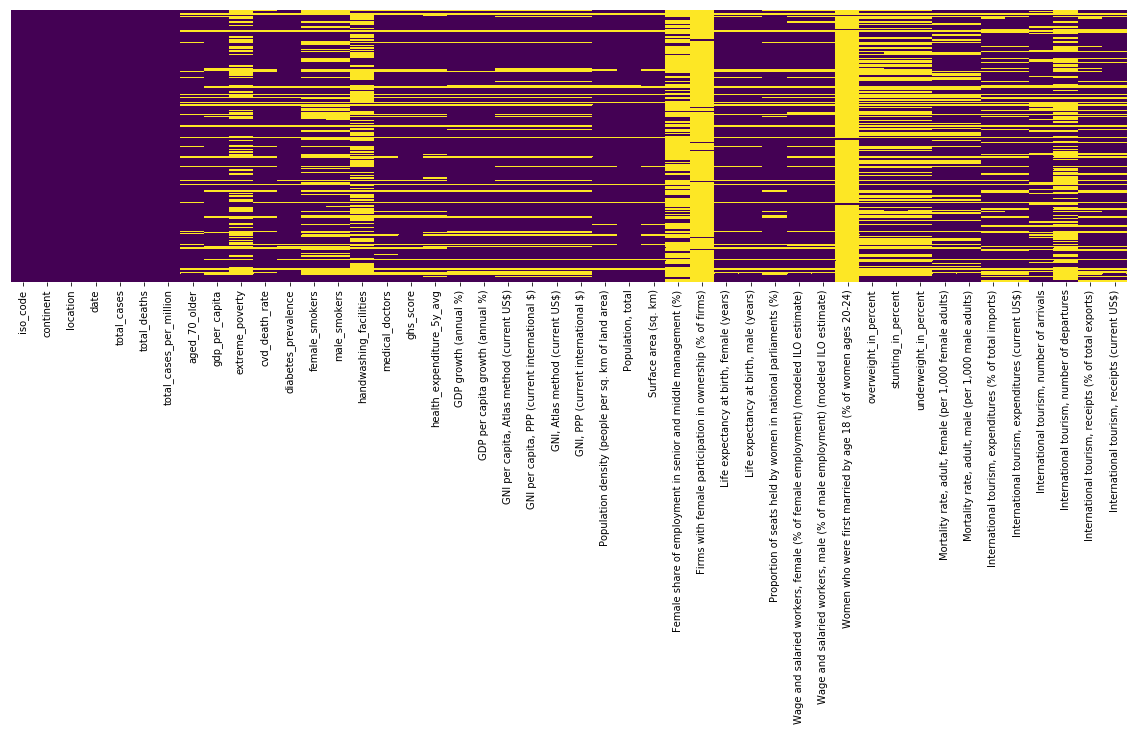

In [16]:
df = df.merge(df_travel_tourism, how = 'left', on = ['iso_code'])

print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

## Lockdown_type and _date per Country

In [17]:
df_lockdown_set = pd.read_csv(FILE_PATH_KAGGLE_LOCKDOWN)
# Generalize provinces of the countries and use earliest lockdown date
df_lockdown_set = df_lockdown_set.sort_values('Date', ascending=True).groupby('Country/Region').first().reset_index()

df_lockdown = df_lockdown_set.loc[:, ['Country/Region', 'Date', 'Type']]
df_lockdown.rename(columns={'Country/Region':'location', 'Date':'lockdown_date', 'Type':'lockdown_type'}, inplace=True)

(209, 48)


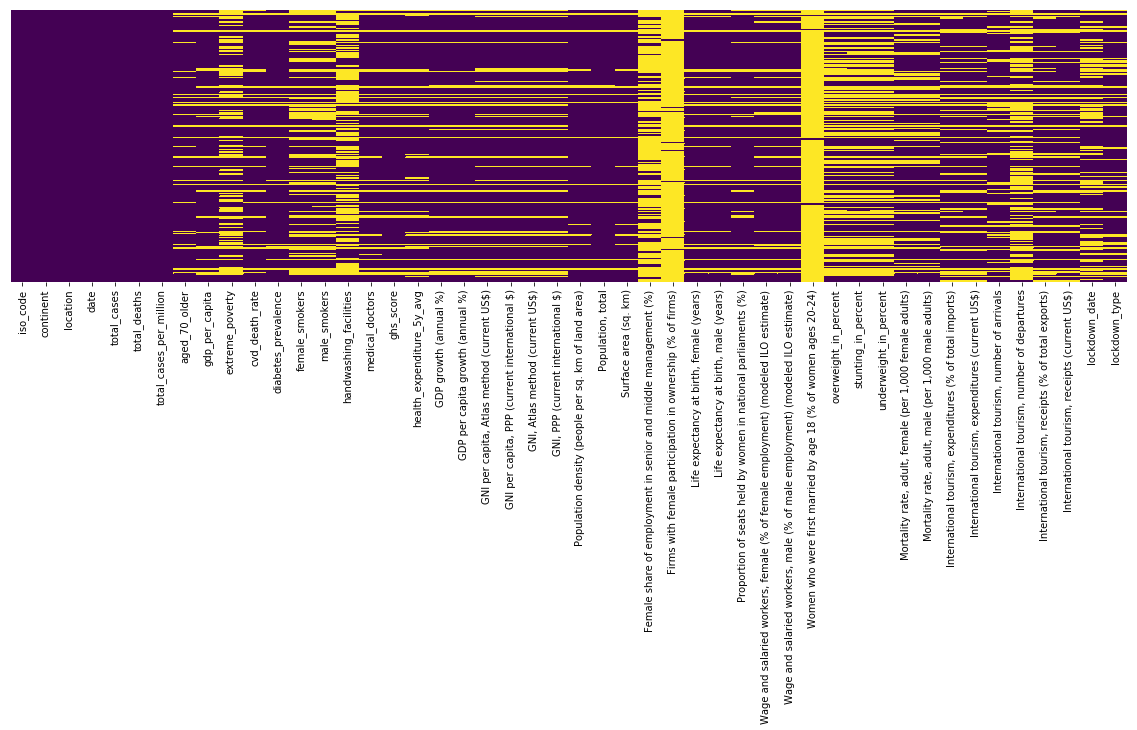

In [18]:
df = df.merge(df_lockdown, how = 'left', on = ['location'])
print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

## Democracy Index

In [19]:
df_democracy_index = pd.read_csv(FILE_PATH_DEMOCRACY_INDEX)
df_democracy_index.rename(columns={'country':'location','score':'di_score',
                                   'electoral_process_and_pluralism':'di_electoral_process_and_pluralism',
                                   'functioning_of_government':'di_functioning_of_government',
                                   'political_participation':'di_political_participation',
                                   'political_culture':'di_political_culture',
                                   'civil_liberties':'di_civil_liberties',
                                   'regime_type':'di_regime_type'}, inplace=True)

def rename_countries_democracy_index(country):
    mapping = { 'Timor-Leste': 'Timor', 'North Macedonia': 'Macedonia', 'Ivory Coast': "Cote d'Ivoire",
               'Eswatini': 'Swaziland', 'Republic of the Congo': 'Congo',
               'Democratic Republic of the Congo': 'Democratic Republic of Congo'
              }
    if (country in mapping and True):
        return mapping[country]
    return country

df_democracy_index['location'] = df_democracy_index['location'].apply(lambda x: rename_countries_democracy_index(x))

# find country names that need to be mapped
countries_di = df_democracy_index['location'].values.tolist()
countries_df = df['location'].values.tolist()
countries_in_di_but_not_df, countries_in_df_but_not_di = [], []
for country in countries_di:
    if (country not in countries_df):
        countries_in_di_but_not_df.append(country)
for country in countries_df:
    if (country not in countries_di):
        countries_in_df_but_not_di.append(country)
#print("countries in di that are not in df", countries_in_di_but_not_df)
#print("\ncountries in df that are not in di", countries_in_df_but_not_di)

df = df.merge(df_democracy_index, how = 'left', on = ['location'])

(209, 55)


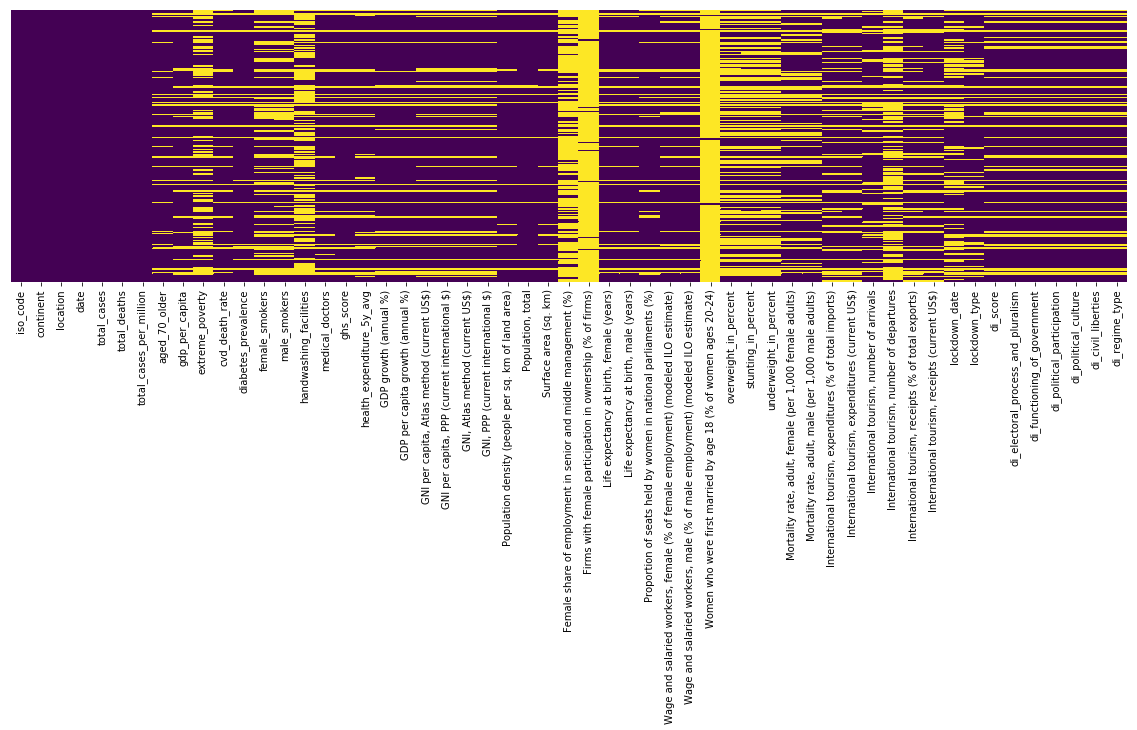

In [20]:
print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

## Size of households

In [21]:
df_households = pd.read_csv(FILE_PATH_UN_HOUSEHOLDS, sep=";")
df_households.rename(columns={'iso':'iso_numeric','average':'household_avg_people',
                             '1_member':'household_members_1',
                             '2_3_members':'household_members_2_3',
                              '4_5_members':'household_members_4_5',
                              '6_or_more_members':'household_members_6_or_more'}, inplace=True)
df_households = df_households.loc[:, ['iso_numeric','reference_date','household_avg_people','household_members_1','household_members_2_3','household_members_4_5','household_members_6_or_more']]
df_households.dropna(inplace=True)

def mapDate(d):
    temp = d.split(".")
    return temp[2] + "-" + temp[1] + "-" + temp[0]
df_households['reference_date'] = df_households['reference_date'].apply(lambda d: mapDate(d))
df_households = df_households.sort_values('reference_date', ascending=False).groupby('iso_numeric').first().reset_index()
def mapIsoNumericToCode3(iso_numeric):
    iso_numeric = int(iso_numeric)
    mapping = {4: 'AFG', 248: 'ALA', 8: 'ALB', 12: 'DZA', 16: 'ASM', 20: 'AND', 24: 'AGO', 660: 'AIA', 10: 'ATA', 28: 'ATG', 32: 'ARG', 51: 'ARM', 533: 'ABW', 36: 'AUS', 40: 'AUT', 31: 'AZE', 44: 'BHS', 48: 'BHR', 50: 'BGD', 52: 'BRB', 112: 'BLR', 56: 'BEL', 84: 'BLZ', 204: 'BEN', 60: 'BMU', 64: 'BTN', 68: 'BOL', 535: 'BES', 70: 'BIH', 72: 'BWA', 74: 'BVT', 76: 'BRA', 86: 'IOT', 96: 'BRN', 100: 'BGR', 854: 'BFA', 108: 'BDI', 132: 'CPV', 116: 'KHM', 120: 'CMR', 124: 'CAN', 136: 'CYM', 140: 'CAF', 148: 'TCD', 152: 'CHL', 156: 'CHN', 162: 'CXR', 166: 'CCK', 170: 'COL', 174: 'COM', 180: 'COD', 178: 'COG', 184: 'COK', 188: 'CRI', 384: 'CIV', 191: 'HRV', 192: 'CUB', 531: 'CUW', 196: 'CYP', 203: 'CZE', 208: 'DNK', 262: 'DJI', 212: 'DMA', 214: 'DOM', 218: 'ECU', 818: 'EGY', 222: 'SLV', 226: 'GNQ', 232: 'ERI', 233: 'EST', 748: 'SWZ', 231: 'ETH', 238: 'FLK', 234: 'FRO', 242: 'FJI', 246: 'FIN', 250: 'FRA', 254: 'GUF', 258: 'PYF', 260: 'ATF', 266: 'GAB', 270: 'GMB', 268: 'GEO', 276: 'DEU', 288: 'GHA', 292: 'GIB', 300: 'GRC', 304: 'GRL', 308: 'GRD', 312: 'GLP', 316: 'GUM', 320: 'GTM', 831: 'GGY', 324: 'GIN', 624: 'GNB', 328: 'GUY', 332: 'HTI', 334: 'HMD', 336: 'VAT', 340: 'HND', 344: 'HKG', 348: 'HUN', 352: 'ISL', 356: 'IND', 360: 'IDN', 364: 'IRN', 368: 'IRQ', 372: 'IRL', 833: 'IMN', 376: 'ISR', 380: 'ITA', 388: 'JAM', 392: 'JPN', 832: 'JEY', 400: 'JOR', 398: 'KAZ', 404: 'KEN', 296: 'KIR', 408: 'PRK', 410: 'KOR', 414: 'KWT', 417: 'KGZ', 418: 'LAO', 428: 'LVA', 422: 'LBN', 426: 'LSO', 430: 'LBR', 434: 'LBY', 438: 'LIE', 440: 'LTU', 442: 'LUX', 446: 'MAC', 807: 'MKD', 450: 'MDG', 454: 'MWI', 458: 'MYS', 462: 'MDV', 466: 'MLI', 470: 'MLT', 584: 'MHL', 474: 'MTQ', 478: 'MRT', 480: 'MUS', 175: 'MYT', 484: 'MEX', 583: 'FSM', 498: 'MDA', 492: 'MCO', 496: 'MNG', 499: 'MNE', 500: 'MSR', 504: 'MAR', 508: 'MOZ', 104: 'MMR', 516: 'NAM', 520: 'NRU', 524: 'NPL', 528: 'NLD', 540: 'NCL', 554: 'NZL', 558: 'NIC', 562: 'NER', 566: 'NGA', 570: 'NIU', 574: 'NFK', 580: 'MNP', 578: 'NOR', 512: 'OMN', 586: 'PAK', 585: 'PLW', 275: 'PSE', 591: 'PAN', 598: 'PNG', 600: 'PRY', 604: 'PER', 608: 'PHL', 612: 'PCN', 616: 'POL', 620: 'PRT', 630: 'PRI', 634: 'QAT', 638: 'REU', 642: 'ROU', 643: 'RUS', 646: 'RWA', 652: 'BLM', 654: 'SHN', 659: 'KNA', 662: 'LCA', 663: 'MAF', 666: 'SPM', 670: 'VCT', 882: 'WSM', 674: 'SMR', 678: 'STP', 682: 'SAU', 686: 'SEN', 688: 'SRB', 690: 'SYC', 694: 'SLE', 702: 'SGP', 534: 'SXM', 703: 'SVK', 705: 'SVN', 90: 'SLB', 706: 'SOM', 710: 'ZAF', 239: 'SGS', 728: 'SSD', 724: 'ESP', 144: 'LKA', 729: 'SDN', 740: 'SUR', 744: 'SJM', 752: 'SWE', 756: 'CHE', 760: 'SYR', 158: 'TWN', 762: 'TJK', 834: 'TZA', 764: 'THA', 626: 'TLS', 768: 'TGO', 772: 'TKL', 776: 'TON', 780: 'TTO', 788: 'TUN', 792: 'TUR', 795: 'TKM', 796: 'TCA', 798: 'TUV', 800: 'UGA', 804: 'UKR', 784: 'ARE', 826: 'GBR', 581: 'UMI', 840: 'USA', 858: 'URY', 860: 'UZB', 548: 'VUT', 862: 'VEN', 704: 'VNM', 92: 'VGB', 850: 'VIR', 876: 'WLF', 732: 'ESH', 887: 'YEM', 894: 'ZMB', 716: 'ZWE'}
    return mapping[iso_numeric]
df_households['iso_code'] = df_households['iso_numeric'].apply(lambda n: mapIsoNumericToCode3(n))
df_households = df_households.loc[:, ['iso_code','household_avg_people','household_members_1','household_members_2_3','household_members_4_5','household_members_6_or_more']]

df = df.merge(df_households, how = 'left', on = ['iso_code'])

(209, 60)


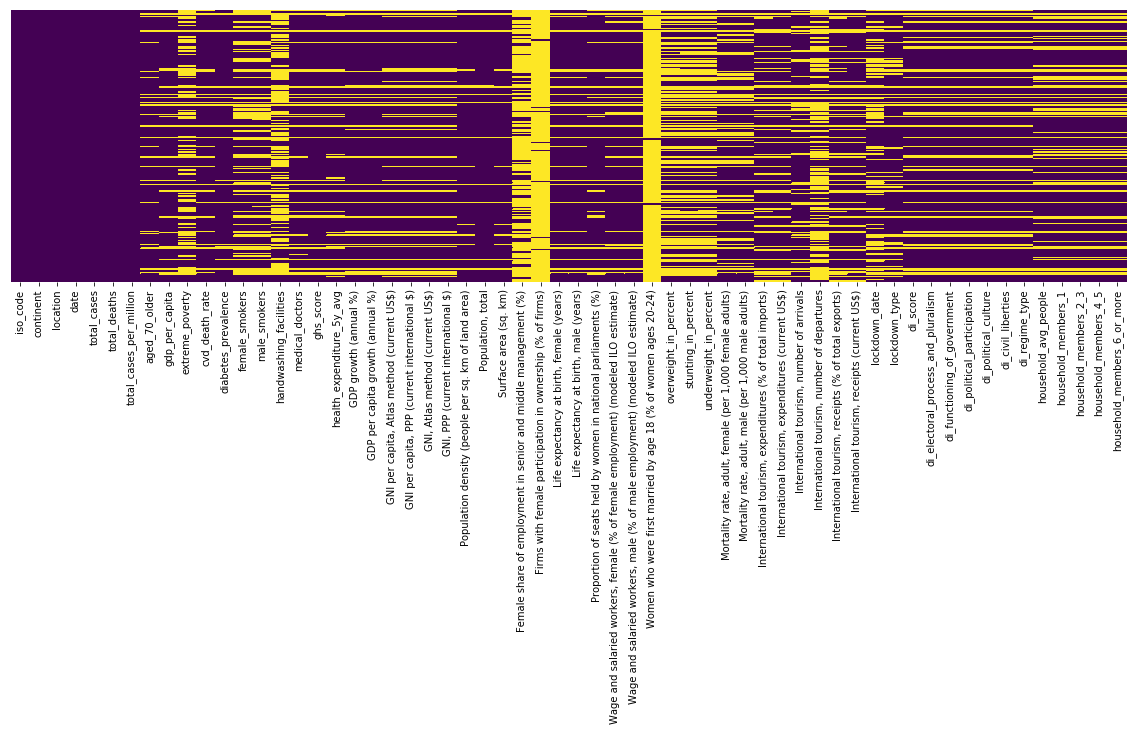

In [22]:
print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)